# ◆Forex forecast USD／JPY
### 目的：為替予測
### 米ドル円の日足にて、売買予測を行う。
- kaggle URL:https://stooq.com/q/d/?s=usdjpy&c=0
- Create Date：2020/01/15　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

### 【手順】

### 0.Notebook内で利用する関数の定義

### 1.データ読込
- 欠損項目を確認する

### 2.データ前処理
- 視覚化

### 3.モデル構築
- 各アルゴリズムのハイパーパラメータ探索を行う。（ロジスティック回帰とSVMを利用）

### 4.モデル評価
- 最良のモデルで汎化性能を算出する。
- 混同行列を作成し、Accuracy、Recall、Precisionを求める

### ※データセット
- 「usdjpy_d.csv」

| 列 | 項目 | 項目名 | 欠損有無 | 利用概要 |
|:---:|:---:|:---:|:---:|:---:|
|  1 | Date| 日付 | - | ○ |
|  2 | Open |始値 | - | ○ |
|  3 | High |高値 | - | ○ |
|  4 | Low |底値 | - | ○ |
|  5 | Close |終値 | - | ○ |

## 0.Notebook内で利用する関数の定義

In [1]:
%matplotlib inline
import datetime
import pandas  as pd
import numpy   as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from time                    import time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.linear_model    import SGDClassifier
from sklearn.svm             import SVC
from sklearn.metrics         import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from IPython.display         import Markdown, display
from matplotlib import ticker
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import matplotlib.dates as mdates
import mpl_finance as mpf
import codecs as cd
import warnings
import mpl_finance
warnings.filterwarnings('ignore')

start_notebook = time()

# ****************************************************************************
# 設定値
# ****************************************************************************

# ▼件数絞込用（時間がかかりすぎるため）
squeeze_num = 1000 # ※1以上の場合有効

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 30)
    
# ============================================================================
# MarkDown記法
# ============================================================================
def printmd(string):
    display(Markdown('\n\n**' + string + '**'))
    
# ============================================================================
# 関数：get_rci
# 引数：終値リスト、期間
# ============================================================================
def get_rci(close, period):
    #時間帯の順位作成
    rank_period = np.arange(period, 0, -1)
    
    length = len(close)
    rci = np.zeros(length)
    
    for i in range(length):
        #rciの数合わせ、最初からperiod-1分は0にする
        if i < period - 1:
            rci[i] = 0
        else :
            #価格順位取得             
            rank_price = pd.Series(close)[i - period + 1: i + 1].rank(method='min', ascending = False).values
            #rci(numpy)を取得
            rci[i] = (1 - (6 * sum((rank_period - rank_price)**2)) / (period**3 - period)) * 100
    return rci



# 1.データ読込

In [11]:
df= pd.read_csv('./input/usdjpy_d.csv',parse_dates=['Date'])

df = df.query('Date >= "2010-01-01"')

# RCI追加
df['rci_5'] = get_rci(df.Close,14)
df['rci_9'] = get_rci(df.Close,9)
df['rci_21'] = get_rci(df.Close,21)
df['rci_52'] = get_rci(df.Close,52)

df = df.query('Date >= "2011-01-01"')

printmd('▼ サイズ')
display(df.shape)

printmd('▼ 直近10行表示')
display(df.tail(10))

printmd('▼ 欠損データ確認')
display(pd.DataFrame(df.isnull().sum()[df.isnull().sum()>0],columns=['Missing num']))



**▼ サイズ**

(2343, 9)



**▼ 直近10行表示**

,Date,Open,High,Low,Close,rci_5,rci_9,rci_21,rci_52
12532,2020-01-06,107.806,108.505,107.774,108.378,-84.175824,-85.000000,-11.688312,21.672501
12533,2020-01-07,108.378,108.628,108.263,108.458,-82.857143,-88.333333,-28.051948,15.534022
12534,2020-01-08,108.459,109.244,107.651,109.078,-76.703297,-58.333333,-35.194805,16.729275
12535,2020-01-09,109.078,109.582,109.013,109.480,-48.131868,1.666667,-36.753247,19.478357
12536,2020-01-10,109.478,109.688,109.437,109.500,-23.516484,48.333333,-33.766234,24.003244
12537,2020-01-13,109.538,109.947,109.534,109.934,9.450549,73.333333,-27.532468,28.707419
12538,2020-01-14,109.935,110.200,109.862,109.988,31.428571,90.000000,-8.441558,32.993255
12539,2020-01-15,109.987,110.001,109.790,109.887,48.571429,95.000000,2.987013,32.967643
12540,2020-01-16,109.887,110.186,109.856,110.178,72.747253,95.000000,22.857143,33.334756
12541,2020-01-17,110.178,110.291,110.051,110.149,84.615385,93.333333,39.480519,35.682575




**▼ 欠損データ確認**

,Missing num


# 2. データ可視化

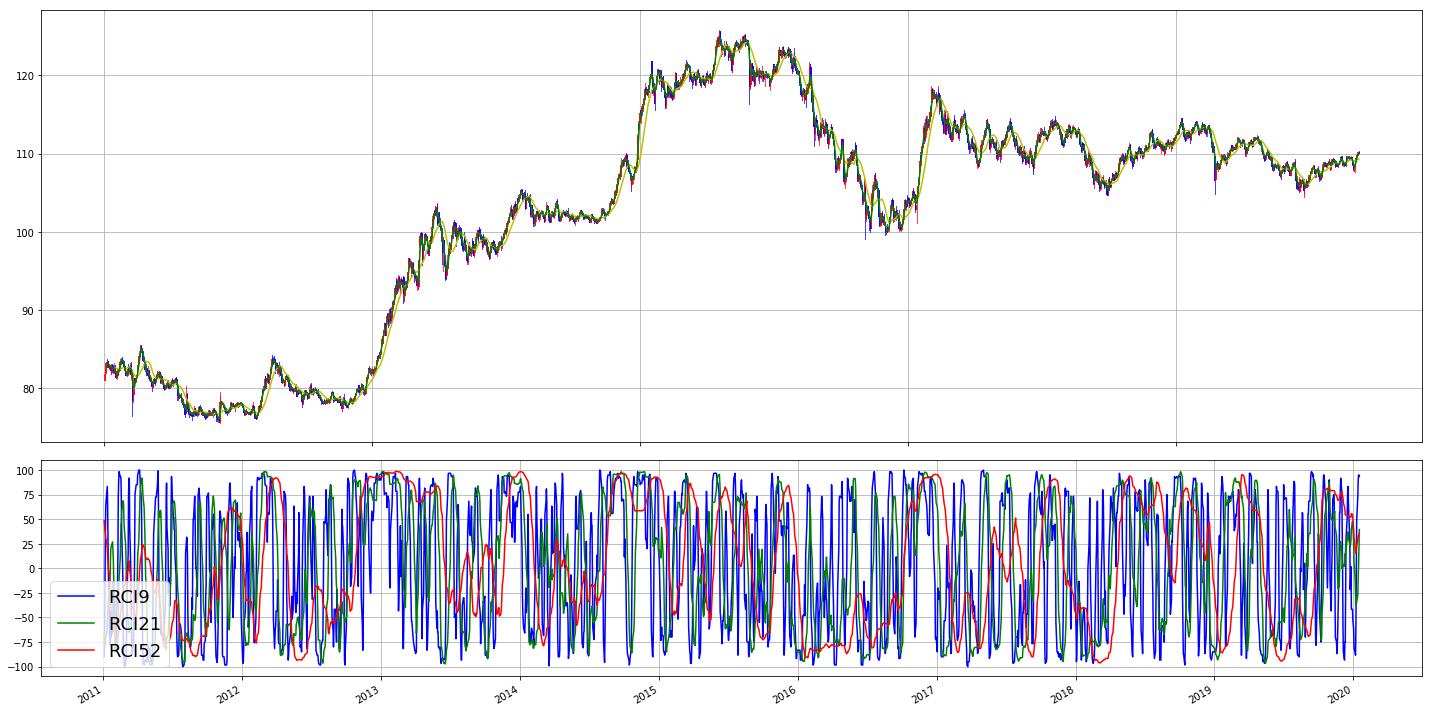

In [12]:
plt.rcParams['figure.figsize'] = [20.0, 10.0]
plt.rc('figure.subplot', left=0.5, right=0.9, bottom=0.1, top=0.9)
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4, 2]})

# --------------------------------------------------------------------------
# ローソク足
mpl_finance.candlestick2_ohlc(ax1,opens=df.Open, highs=df.High, lows=df.Low, closes=df.Close, 
                              width=1,colorup='r', colordown='b')
# x軸を時間にする
xdate = df.index
ax1.xaxis.set_major_locator(ticker.MaxNLocator(6))
ax1.grid(b=True, which='major', axis='both') #グリッド表示
def mydate(x, pos):
    try:
        return xdate[int(x)]
    except IndexError:
        return ''

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))
ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()
fig.tight_layout()

# --------------------------------------------------------------------------
# sma21
sma = df.Close.rolling(21).mean()
vstack = np.vstack((range(len(sma)), sma.values.T)).T  # x軸データを整数に
ax1.plot(vstack[:, 0], vstack[:, 1], color='y', label='SMA21')

# --------------------------------------------------------------------------
# sma5
sma = df.Close.rolling(5).mean()
vstack = np.vstack((range(len(sma)), sma.values.T)).T  # x軸データを整数に
ax1.plot(vstack[:, 0], vstack[:, 1], color='g', label='SMA5')

# --------------------------------------------------------------------------
# テクニカルチャート
ax2.plot(df['Date'], df['rci_9'], color='b', antialiased=True, label='RCI9')
ax2.plot(df['Date'], df['rci_21'], color='g', antialiased=True, label='RCI21')
ax2.plot(df['Date'], df['rci_52'], color='r', antialiased=True, label='RCI52')
ax2.grid(b=True, which='major', axis='both') #グリッド表示

# --------------------------------------------------------------------------

plt.legend(loc='lower left',fontsize=18)
fig.tight_layout()
plt.show()


### 翌日終値が当日終値よりも上昇するかを予測する

In [13]:
# 翌日終値 - 当日終値で差分を計算
df['Close_1DayAdd'] = df.Close.shift(-1)
df['Diff'] = df['Close_1DayAdd'] - df['Close']
df = df[:-1]

# 上昇したら「1」、下降したら「0」へデータを変換
mask1 = df['Diff'] >= 0   # 上昇した
mask2 = df['Diff'] < 0  # 下落した
column_name = 'Diff'
df.loc[mask1, 'Target'] = 1
df.loc[mask2, 'Target'] = 0

#df.rename(columns={'Diff' : 'Target'}, inplace=True)

# 最初の5行を表示
display(df.tail(10))


,Date,Open,High,Low,Close,rci_5,rci_9,rci_21,rci_52,Close_1DayAdd,Diff,Target
12531,2020-01-03,108.547,108.631,107.851,108.101,-64.835165,-81.666667,6.103896,31.345514,108.378,0.277,1.0
12532,2020-01-06,107.806,108.505,107.774,108.378,-84.175824,-85.000000,-11.688312,21.672501,108.458,0.080,1.0
12533,2020-01-07,108.378,108.628,108.263,108.458,-82.857143,-88.333333,-28.051948,15.534022,109.078,0.620,1.0
12534,2020-01-08,108.459,109.244,107.651,109.078,-76.703297,-58.333333,-35.194805,16.729275,109.480,0.402,1.0
12535,2020-01-09,109.078,109.582,109.013,109.480,-48.131868,1.666667,-36.753247,19.478357,109.500,0.020,1.0
12536,2020-01-10,109.478,109.688,109.437,109.500,-23.516484,48.333333,-33.766234,24.003244,109.934,0.434,1.0
12537,2020-01-13,109.538,109.947,109.534,109.934,9.450549,73.333333,-27.532468,28.707419,109.988,0.054,1.0
12538,2020-01-14,109.935,110.200,109.862,109.988,31.428571,90.000000,-8.441558,32.993255,109.887,-0.101,0.0
12539,2020-01-15,109.987,110.001,109.790,109.887,48.571429,95.000000,2.987013,32.967643,110.178,0.291,1.0
12540,2020-01-16,109.887,110.186,109.856,110.178,72.747253,95.000000,22.857143,33.334756,110.149,-0.029,0.0


In [16]:
# データセットの行数、列数を取得
split_row = np.int(0.99 * df.shape[0])

X_all_df = df.drop(['Date','Close_1DayAdd','Diff','Target'], axis=1)
X_all = X_all_df.values
y_all = df['Target'].values

X_train = X_all[:split_row, :]
y_train = y_all[:split_row]

X_test = X_all[split_row+1:,:]
y_test = y_all[split_row+1:]

# 訓練データとテストデータのサイズを確認
print(X_train.shape)
print(X_test.shape)

(2318, 8)
(23, 8)




**▼ 重みを表示（絶対値の降順：Top10）**

,feature,weight
0,Open,160.960062
1,Close,-106.260797
2,Low,-80.024011
3,High,28.818284
4,rci_52,-7.431719
5,rci_5,4.526244
6,rci_9,1.390029
7,rci_21,1.114068




**▼ 重みの大きさを横棒グラフで表示**

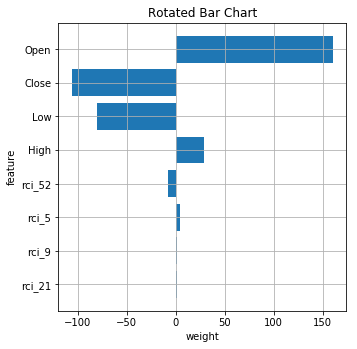



**▼ モデルの予測結果(先頭10件)**

[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]




**▼ 結果の予測確率(先頭10件)
(上昇しない確率：上昇する確率):**

[[1.00000000e+00 5.74672922e-73]
 [1.00000000e+00 3.59749179e-28]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]]




**▼ モデルの評価結果**

正答率（訓練データ） = 51.165%
正答率（テストデータ）= 39.130%
適合率（Precision※精度) = 33.333%
再現率（Recall※検出率) = 27.273%
F1値（F1-score） = 30.000%




**▼ 混同行列**

,予測 = 翌日上昇しない,予測 = 翌日上昇する
正解 = 翌日上昇しない,3,8
正解 =翌日上昇する,6,6


In [17]:
# ロジスティック回帰モデル生成
clf = SGDClassifier(loss='log',penalty='none',max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)

# 学習
clf.fit(X_train, y_train)

#print('w0 = {:.3f}'.format(clf.intercept_[0]))

# 結果をDataFrameへ格納
res_df = pd.DataFrame(columns=['feature','weight','abs_w'])
res_df['feature'] = list(X_all_df.columns)
res_df['weight'] = np.reshape(clf.coef_[0], -1).tolist() # 重み
res_df['abs_w'] = abs(res_df['weight']) # 絶対値

# 重みの絶対値の降順ソート
printmd('▼ 重みを表示（絶対値の降順：Top10）')
res_df = res_df.sort_values('abs_w', ascending=False)
res_df.reset_index(drop=True,inplace=True)
res_df = res_df.drop('abs_w', axis=1)
res_df_head = res_df.head(10)
display(res_df_head.head(10))

# 重みの大きさを横棒グラフで表示
printmd('▼ 重みの大きさを横棒グラフで表示')
plt.figure(figsize=(10, 5))
plt.barh(np.arange(len(res_df_head['feature']))[::-1], res_df_head['weight'], align='center')
plt.yticks(np.arange(len(res_df_head['feature']))[::-1], res_df_head['feature'])
plt.title('Rotated Bar Chart')
plt.xlabel('weight')
plt.ylabel('feature')
plt.grid()
plt.show()

y_train_pred = clf.predict(X_train) # 訓練データ
y_test_pred = clf.predict(X_test) # テストデータ

printmd('▼ モデルの予測結果(先頭10件)')
print(y_test_pred[:11])

printmd('▼ 結果の予測確率(先頭10件)\n(上昇しない確率：上昇する確率):')
print(clf.predict_proba(X_test)[:11])

printmd('▼ モデルの評価結果')
print('正答率（訓練データ） = {:.3f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('正答率（テストデータ）= {:.3f}%'.format(100 * accuracy_score(y_test, y_test_pred)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
print('適合率（Precision※精度) = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall※検出率) = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
printmd('▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = 翌日上昇しない', '正解 =翌日上昇する'], 
                        columns=['予測 = 翌日上昇しない', '予測 = 翌日上昇する'])

display(conf_mat)

In [21]:
# 決定木モデル生成
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=15, min_samples_leaf=20, random_state=1234)
dt.fit(X_train, y_train)


y_train_pred = dt.predict(X_train) # 訓練データ
y_test_pred = dt.predict(X_test) # テストデータ

printmd('▼ モデルの評価結果')
print('正答率（訓練データ）= {:.3f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('正答率（テストデータ）= {:.3f}%'.format(100 * accuracy_score(y_test, y_test_pred)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
print('適合率（Precision※精度) = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall※検出率) = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
printmd('▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = 翌日上昇しない', '正解 =翌日上昇する'], 
                        columns=['予測 = 翌日上昇しない', '予測 = 翌日上昇する'])

display(conf_mat)



**▼ モデルの評価結果**

正答率（訓練データ）= 56.083%
正答率（テストデータ）= 60.870%
適合率（Precision※精度) = 55.000%
再現率（Recall※検出率) = 100.000%
F1値（F1-score） = 70.968%




**▼ 混同行列**

,予測 = 翌日上昇しない,予測 = 翌日上昇する
正解 = 翌日上昇しない,11,0
正解 =翌日上昇する,9,3


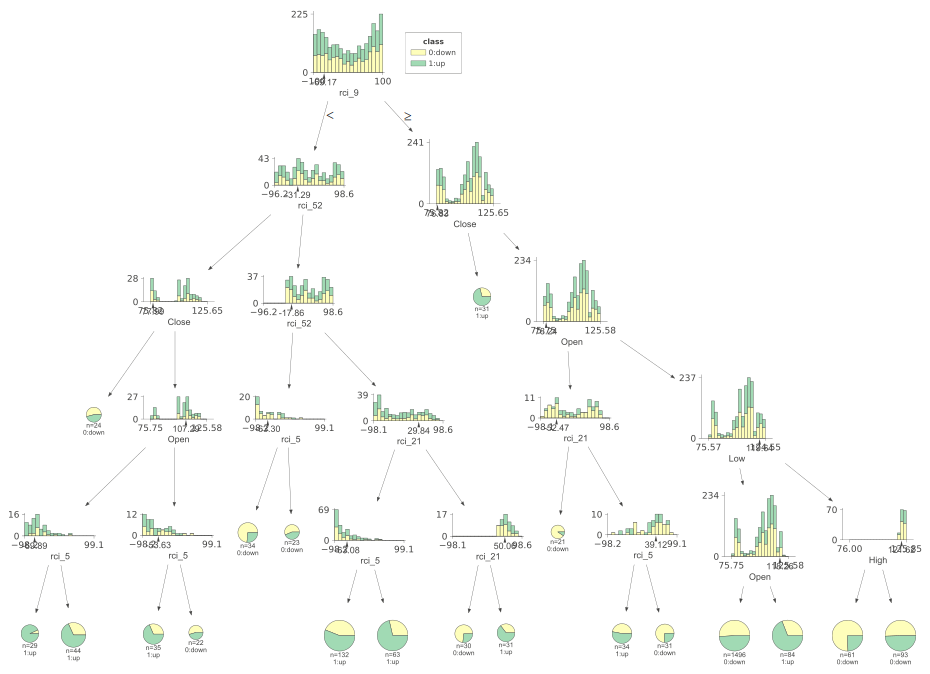

In [22]:
from sklearn.datasets import *
from sklearn import tree
from dtreeviz.trees import *
import graphviz

viz = dtreeviz(dt,X_train=X_train,
               y_train=y_train,
               target_name='class',
               class_names=['0:down','1:up'],
               ticks_fontsize=12.0,
               feature_names=X_all_df.columns)
              
display(viz)